In [143]:
library(stringr)
library(parallel)
library(pheatmap)
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(plot3D))
suppressPackageStartupMessages(library(scales))

## Examples of peaks that change by time

In [2]:
setwd('/nfs/lab/projects/islet_cytok/analysis/deseq_matrix')

In [3]:
meta = read.table("metadata_atac", header= T)

In [4]:
meta2 = read.table("cytokine_35.metadata.txt", header=T)

In [5]:
sum(meta2$treatment %in% meta$Internal_Data_Label)

[1] 35

In [6]:
meta = merge(meta, meta2[,c('treatment','time','bam')], by.x="Internal_Data_Label", by.y="treatment")

In [162]:
raw = read.table("cytPeak.dec9.matrix.filtered.R", header=T, row.names=1)

In [8]:
sum(meta$bam %in% colnames(raw))

[1] 35

In [9]:
mat <- limma::voom(raw)
mat_corrected <- limma::removeBatchEffect(mat, batch= meta$Islet_ID)

In [10]:
u= read.table("../deseq_ATAC_NEW_bedfiles/annotated_peaks.tsv", header=T)
u = subset(u, rowSums(u)>0)

In [11]:
testmat = subset(mat_corrected, rownames(mat_corrected)%in% rownames(u))

In [12]:
samp1 = subset(meta, Treatment_label == '3cyt-hi')

In [13]:
samp2 = subset(meta, Treatment_label == 'untreat')

In [14]:
m1 = subset(testmat, select = as.character(samp1$bam))

In [15]:
m2 = subset(testmat, select = as.character(samp2$bam))

In [16]:
dim(m2)

[1] 44969    13

In [17]:
calc_lm = function(i){
df = data.frame(samp$time, test[i,])
p = summary(lm(df[,2]~df[,1]))$coefficients[2,4]
    return(p)
    }

In [18]:
calc_lm_cov = function(i){
df = data.frame(samp$time, test[i,], samp$Treatment_label)
p = summary(lm(df[,2]~df[,1] +df[,3]))$coefficients[2,4]
    return(p)
    }

In [19]:
test = m1
samp = samp1
pvalues1 = mclapply(1:nrow(test),calc_lm, mc.cores = 32 )

In [20]:
test = m2
samp = samp2
pvalues2 = mclapply(1:nrow(test),calc_lm, mc.cores = 32 )

In [21]:
dim(test)

[1] 44969    13

In [22]:
samp = subset(meta, Treatment_label %in% c('3cyt-hi','untreat'))
test = subset(testmat, select = as.character(samp$bam))
pvalues3 = mclapply(1:nrow(test),calc_lm_cov, mc.cores = 32 )

In [23]:
res= data.frame(peak = rownames(testmat), pval_cyt = unlist(pvalues1), 
                pval_unt = unlist(pvalues2),pval_cov = unlist(pvalues3))

In [24]:
res$qval_cyt = p.adjust(res$pval_cyt)
res$qval_unt = p.adjust(res$pval_unt)
res$qval_cov = p.adjust(res$pval_cov)

In [25]:
res= res[order(res$qval_cov, -res$pval_unt) ,]

In [26]:
sum(res$qval_cyt<0.1)
sum(res$qval_unt<0.1)
sum(res$qval_cov<0.1)

[1] 1

[1] 0

[1] 5

In [27]:
res_sub = subset(res, pval_unt>0.05)

In [28]:
dir = '/nfs/lab/projects/islet_cytok/analysis/deseq_ATAC_NEW/'

In [29]:
fi = list.files(dir)[grepl('Hi.dec16',list.files(dir))]

In [30]:
for (ff in 1:4 ){
    
    file = read.table(paste0(dir, fi[ff]), header=T, row.names = 1)
    if(ff==1){dt=data.frame(file$log2FoldChange)}else{
    dt=cbind(dt,file$log2FoldChange)}
    
}

In [31]:
rownames(dt)= rownames(file)
colnames(dt) = c(24,48,6,72)

In [32]:
dts = subset(dt, rownames(dt)%in% rownames(u))

In [33]:
dim(dts)

[1] 44969     4

In [34]:
calc_lm_fc = function(i, ret = "pval"){
df = data.frame(as.numeric(colnames(test)), unlist(test[i,]))
p = summary(lm(df[,2]~df[,1]))$coefficients[2,4]
b = summary(lm(df[,2]~df[,1]))$coefficients[2,1]
   if(ret=="pval") {return(p)}
     if(ret=="beta") {return(b)}
    }

In [35]:
test=dts
dts$pval = unlist(mclapply(1:nrow(test),calc_lm_fc, mc.cores = 32 ))

In [36]:
dts$beta = unlist(mclapply(1:nrow(test),calc_lm_fc,ret = "beta", mc.cores = 32 ))

In [38]:
dts$qval = p.adjust(dts$pval)

In [182]:
dts = dts[order(dts$pval),]

In [183]:
dts[dts$beta<0 & dts$pval<0.001,]

,24,48,6,72,pval,beta,qval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak-chr6-16420973-16422131,0.88638796,0.7176341,1.00867573,0.55215065,1.671509e-05,-0.006931381,0.7516107
peak-chr1-22746800-22747453,-0.41686283,-0.5554921,-0.31657842,-0.69023638,2.126654e-05,-0.005675133,0.9562501
peak-chr1-48209765-48210438,-0.66470146,-1.0103380,-0.39201319,-1.35979692,4.506801e-05,-0.014626124,1.0000000
peak-chr3-54815793-54816043,-0.46705112,-1.1701473,0.08835114,-1.87838708,5.207013e-05,-0.029724756,1.0000000
peak-chr16-71156233-71156618,-1.00774157,-1.1885205,-0.86835666,-1.37938572,6.071780e-05,-0.007721425,1.0000000
peak-chr15-82397499-82398321,-0.36974226,-0.4545967,-0.30274126,-0.54566234,9.669580e-05,-0.003664948,1.0000000
peak-chr15-45329104-45330199,-0.37905414,-0.4558712,-0.31935311,-0.53032285,9.692102e-05,-0.003194316,1.0000000
peak-chr12-111165524-111166579,1.90204072,1.5023020,2.21778345,1.07275320,1.002660e-04,-0.017274171,1.0000000
peak-chr2-205124849-205125407,-0.15921599,-0.5164024,0.11262553,-0.89799525,1.119292e-04,-0.015273273,1.0000000


In [40]:
table(dts$beta>0)


FALSE  TRUE 
21557 23412 

### Find example related to TNFa +/-

In [41]:
list.files(dir)

[1] "cytokine_24hr_Hi.dec16.filtered.txt" 
[2] "cytokine_24hr_Hi2.dec16.filtered.txt"
[3] "cytokine_24hr_Lo.dec16.filtered.txt" 
[4] "cytokine_24hr_Lo2.dec16.filtered.txt"
[5] "cytokine_4h8r_Hi.dec16.filtered.txt" 
[6] "cytokine_6hr_Hi.dec16.filtered.txt"  
[7] "cytokine_72hr_Hi.dec16.filtered.txt" 
[8] "cytokine_all.jan4.filtered.txt"      
[9] "cytokine_hiVhi2.feb3.filtered.txt"

In [42]:
tn = read.table(paste0(dir, 'cytokine_hiVhi2.feb3.filtered.txt'), header=T, row.names = 1)

In [43]:
sum (tn$padj<0.1, na.rm=T)

[1] 0

In [44]:
tn = tn[order(tn$pvalue),]

In [47]:
head(tn,15)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak-chr8-134440603-134441786,275.83686,0.6695062,0.2044839,3.274127,0.001059890,0.9999986
peak-chr12-105323919-105324985,129.92522,-0.8807923,0.2690644,-3.273538,0.001062103,0.9999986
peak-chr6-143856196-143856717,99.01570,0.9606471,0.2998400,3.203865,0.001355960,0.9999986
peak-chr11-46395274-46396000,256.92764,-0.6321598,0.2011966,-3.142000,0.001677983,0.9999986
peak-chr2-80182467-80183251,143.40565,-0.7786214,0.2504090,-3.109398,0.001874687,0.9999986
peak-chr22-18264007-18264967,231.50339,-0.7601547,0.2455183,-3.096122,0.001960696,0.9999986
peak-chr1-234613765-234615257,935.38236,0.3785343,0.1242450,3.046677,0.002313860,0.9999986
peak-chr2-129590362-129591170,158.18383,0.7755570,0.2547504,3.044380,0.002331602,0.9999986
peak-chr12-92924303-92925071,144.70511,-0.8372558,0.2766418,-3.026497,0.002474050,0.9999986


In [48]:
table(meta$Treatment_label)


2cyt-hi 2cyt-lo 3cyt-hi 3cyt-lo untreat 
      5       3      11       3      13 

In [49]:
meta$tnf = substr(meta$Treatment_label,1,4)

In [50]:
meta$lohi = substr(meta$Treatment_label,6,7)

In [51]:
calc_lm_tnf = function(i){
df = data.frame(samp$tnf, test[i,], samp$lohi)
p = summary(lm(df[,2]~df[,1] +df[,3]))$coefficients[2,4]
    return(p)
    }

In [52]:
samp = subset(meta, time==24 & Treatment_label!= 'untreat')
test = subset(testmat, select = as.character(samp$bam))
pvalues_tnf = mclapply(1:nrow(test),calc_lm_tnf, mc.cores = 32 )

In [53]:
restn = data.frame(rownames(test), pval = unlist(pvalues_tnf))
restn = restn[order(restn$pval) ,]

In [54]:
head(restn)

,rownames.test.,pval
,<fct>,<dbl>
18346,peak-chr18-68036225-68036492,0.0004271357
26970,peak-chr3-73522907-73523251,0.0012313239
32626,peak-chr5-76573717-76573941,0.0016449717
23154,peak-chr2-234351508-234351881,0.0017263794
33742,peak-chr5-141190913-141191925,0.0031812635
20654,peak-chr2-61886055-61887220,0.0034631906


In [169]:
meta_sub = droplevels(subset(meta, lohi=='hi' & Duration=="24h"))

In [177]:
table(meta_sub$Treatment_label)


2cyt-hi 3cyt-hi 
      5       5 

In [174]:
tab_sub = droplevels(subset(raw, select = as.character(meta_sub$bam)))

In [176]:
dds <-DESeqDataSetFromMatrix(tab_sub, colData = meta_sub, design = ~ Treatment_label + Islet_ID)


  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]



In [178]:
dds     <- DESeq(dds)    
res     <- results(dds, contrast=c("Treatment_label", "3cyt-hi", "2cyt-hi")  )
   res     = res[order(res$pvalue),]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a

In [55]:
dir = '/nfs/lab/projects/islet_cytok/analysis/deseq_ATAC_NEW/'

In [56]:
files = list.files(dir)[1:7]

In [57]:
for(i in 1:7){
    df = read.table(paste0(dir, files[i]), header=T)
    if (i==1){
        re = df[,"log2FoldChange"]
    } else{
        re = cbind(re, df[,"log2FoldChange"])
    }
}

In [58]:
rownames(re )=rownames(df)

In [59]:
colnames(re) = c("3cyt-hi-24", "2cyt-hi-24","3cyt-lo-24",'2cyt-lo-24','3cyt-hi-48','3cyt-hi-6','3cyt-hi-71')

In [60]:
re = subset(re, rownames(re) %in% rownames(u))

In [70]:
re = re[,c(4,3,2,6,1,5,7)]

In [61]:
pheatmap(re, file = "heatmap_fc.pdf", show_rownames = FALSE, 
         breaks = seq(-max(abs(re)), max(abs(re)), length.out = 100))

In [62]:
mydata <- t(apply(re, 1, scale))

####  kmeans clustering

In [63]:
nclust = 3
fit <- kmeans(mydata, nclust) 
# get cluster means
km =aggregate(mydata,by=list(fit$cluster),FUN=mean)
km=km[,-1]
colnames(km) = colnames(re)

In [64]:
km = km[,c(4,3,2,6,1,5,7)]

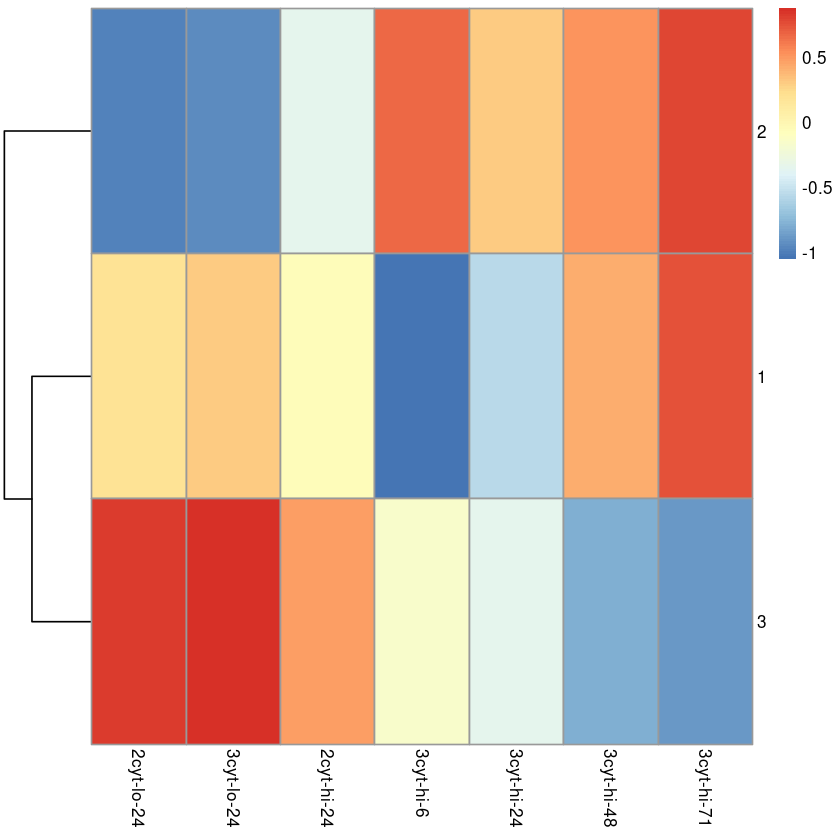

In [65]:
pheatmap(km, cluster_cols = FALSE)

In [66]:
dim(mydata)
dim(u)

[1] 44969     7

[1] 44969    14

In [67]:
annopeak = data.frame(dif06 = apply(u[,c('cytokine_6hr_Hi.up','cytokine_6hr_Hi.down')], 1, function(x) paste (as.numeric(x), collapse="")) ,
                      dif24 = apply(u[,c('cytokine_24hr_Hi.up','cytokine_24hr_Hi.down')], 1, function(x) paste (as.numeric(x), collapse="")) ,
                      dif48 = apply(u[,c('cytokine_48hr_Hi.up','cytokine_48hr_Hi.down')], 1, function(x) paste (as.numeric(x), collapse="")) ,
                      dif72 = apply(u[,c('cytokine_72hr_Hi.up','cytokine_72hr_Hi.down')], 1, function(x) paste (as.numeric(x), collapse="")) ,
                      dif2cythi = apply(u[,c('cytokine_24hr_Hi2.up','cytokine_24hr_Hi2.down')], 1, function(x) paste (as.numeric(x), collapse="")) ,          
                      dif3cytlo = apply(u[,c('cytokine_24hr_Lo.up','cytokine_24hr_Lo.down')], 1, function(x) paste (as.numeric(x), collapse="")) ,          
                      dif2cytlo =  apply(u[,c('cytokine_24hr_Lo2.up','cytokine_24hr_Lo2.down')], 1, function(x) paste (as.numeric(x), collapse="")) )          
                        
rownames(annopeak)  = rownames(u)                               


In [80]:
km_clust = brewer.pal(nclust, "Spectral")
names(km_clust) = 1:nclust

diff24 = brewer.pal(3, "Set1")[1:2]
names(diff24) = c('10', '01')
colorlist = list( dif06 =diff24, dif24=diff24, dif48 =diff24, dif72 =diff24, 
                 dif2cythi =diff24, dif3cytlo=diff24, dif2cytlo =diff24, 
                 km_clust=km_clust )



In [ ]:

# nclust = 6
# fit <- kmeans(mydata, nclust) 

# annopeak3 = data.frame(annopeak, km_clust = as.character(fit$cluster))
# annopeak3[annopeak3=="00"]<-NA
# annopeak3 = as.data.frame(annopeak3)

# table(annopeak3$km_clust)

# table(annopeak3$km_clust)



# pheatmap(re, cluster_rows = T, cluster_cols = F, treeheight_row = FALSE,
#          show_rownames = F,
#          #col = rev(colorRampPalette(brewer.pal(9, "PuOr"))(50)),
#          annotation_row=annopeak3,
#          annotation_colors = colorlist,
#           cellwidth=15, 
#          file ="heatmap_fc_kmclust.pdf",
#          scale = 'row', 
#          fontsize = 10)

#### Separate  up and downregulated and direction of change

In [68]:
annopeak$up = rowSums(annopeak=='10')>0
annopeak$down = rowSums(annopeak=='01')>0

In [69]:
table(annopeak$up, annopeak$down)

       
        FALSE  TRUE
  FALSE     0 22092
  TRUE  22830    47

In [71]:
sum(dts$pval<0.01)

[1] 1000

In [72]:
sigT = rownames(dts)[dts$pval<0.01]

In [75]:
dts = dts[match(rownames(annopeak), rownames(dts)),]

annopeak$beta = as.numeric(dts$beta>0)
annopeak$categ = apply(annopeak[,c('up','down','beta')],  1, function(x) paste (as.numeric(x), collapse=""))
annopeak$beta_val = dts$beta
annopeak$pval = dts$pval
ann = annopeak[sigT,]
ann = ann[order( ann$up, ann$beta_val, -ann$beta_val, decreasing=F), ]
ann = ann[!(ann$categ %in% c('000', '001', '111')), ]

ann = ann[!(ann$categ %in% c('000', '001', '111')),c(1:4,11) ]
ann[ann=="00"]<-NA

In [81]:
categ = brewer.pal(4, "Paired")
names(categ)=c('011', '010','101','100')
colnew = colorlist[1:4]
colnew[['categ']]=categ

In [180]:
table(ann$categ)


010 011 100 101 
234 196 121 444 

In [84]:
pheatmap(re[sigT,4:7], cluster_rows = T, cluster_cols = T, treeheight_row = FALSE,
         show_rownames = F,
         #col = rev(colorRampPalette(brewer.pal(9, "PuOr"))(50)),
         annotation_row=ann,
         annotation_colors = colnew,
          cellwidth=15, 
         file ='heatmap_fc_time_sig.png',
         scale = 'row', 
         fontsize = 10)

In [85]:
pheatmap(re[sigT,4:7], cluster_rows = T, cluster_cols = T, treeheight_row = FALSE,
         show_rownames = F,
         #col = rev(colorRampPalette(brewer.pal(9, "PuOr"))(50)),
         annotation_row=ann,
         annotation_colors = colnew,
          cellwidth=15, 
         file ='heatmap_fc_time_sig_noscale.png',
         #scale = 'row', 
         fontsize = 10)

In [88]:
pheatmap(re[as.character(rownames(ann)),4:7], cluster_rows = F, cluster_cols = T, treeheight_row = FALSE,
         show_rownames = F,
         #col = rev(colorRampPalette(brewer.pal(9, "PuOr"))(50)),
         annotation_row=ann,
         annotation_colors = colnew,
          cellwidth=15, 
          scale = 'row', 
         file ='heatmap_fc_time_sig_noclust.png',
         fontsize = 10)

In [90]:
pheatmap(re[as.character(rownames(ann)),4:7], cluster_rows = F, cluster_cols = T, treeheight_row = FALSE,
         show_rownames = F,
         #col = rev(colorRampPalette(brewer.pal(9, "PuOr"))(50)),
         annotation_row=ann,
         annotation_colors = colnew,
          cellwidth=15, 
         file ='heatmap_fc_time_sig_noscale_noclust.pdf',
         fontsize = 10)

## motif analysis

In [95]:
beddir ="/nfs/lab/projects/islet_cytok/analysis/deseq_ATAC_NEW_bedfiles"
hdir = "/nfs/lab/projects/islet_cytok/analysis/HOMER_diff_sites/"

run_homer = function(bedfile, outdir,bgfile )
{
    system(paste ('findMotifsGenome.pl', bedfile, '/nfs/lab/KG/ref/male.masked.hg19.fa', 
       outdir,  '-bg', bgfile,  '-nomotif' ))
}

In [293]:
bed = str_split_fixed(rownames(ann), "\\-", 4)[,2:4]

In [296]:
unique(ann$categ)

[1] "010" "011" "100" "101"

In [297]:
for (x in unique(ann$categ)){
    write.table(bed[ann$categ==x,], paste0(hdir, "timecourse.", x,".bed"),
    sep="\t", quote=F, row.names=F, col.names=F)


}

In [287]:
lf    = list.files(beddir)
bup   = lf[grepl("up",lf) & grepl("All",lf)]
bdown = lf[grepl("down",lf) & grepl("All",lf)]

In [92]:
ups   = c('timecourse.100.bed','timecourse.101.bed')
downs = c('timecourse.010.bed','timecourse.011.bed')

In [301]:
mclapply(1:2, function (i) run_homer(paste(hdir,ups[i], sep="/"), 
                                               paste0(hdir,gsub(".bed", "", ups[i]) ), 
                                               paste(beddir,bup, sep="/")),mc.cores = 18)

[[1]]
[1] 0

[[2]]
[1] 0

In [ ]:
mclapply(1:2, 
         function (i) run_homer(paste(hdir,downs[i], sep="/"), paste0(hdir,gsub(".bed", "", downs[i]) ), 
                                paste(beddir,bdown, sep="/")),mc.cores = 18)
  

In [93]:
exps = gsub(".bed", "",c(ups, downs))

In [94]:
exps

[1] "timecourse.100" "timecourse.101" "timecourse.010" "timecourse.011"

In [115]:
dl = list()
for (exp in exps){
hom= read.table( paste0(hdir, exp, '/knownResults.txt'), header=F, fill=T, check.names=F, skip=1, stringsAsFactors = F)
hom$fold_change = as.numeric(gsub('%',"", hom$V7)) /(as.numeric(gsub('%',"", hom$V9))+0.1) ##pseudocount for inf (only V2)
hom$Motif = str_split_fixed(hom$V1, "\\/",3)[,1]
hom = hom[complete.cases(hom),] 
hom = subset(hom, Motif !="SEQBIAS:") 
hom$Qval = p.adjust(as.numeric(hom$V3), method = "BH")
hom$LogP = -log(as.numeric(as.numeric(hom$V3)),10)
tab = hom[,c("Motif","fold_change", "Qval", "LogP")]
tab = tab[complete.cases(tab),]
tab$treat = exp
    dl[[exp]] = tab
}

logp =sapply(dl, function(x) unlist(x$LogP)[1:10])



Warning message in p.adjust(as.numeric(hom$V3), method = "BH"):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in p.adjust(as.numeric(hom$V3), method = "BH"):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in p.adjust(as.numeric(hom$V3), method = "BH"):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in p.adjust(as.numeric(hom$V3), method = "BH"):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [104]:
getwd()

[1] "/nfs/lab/projects/islet_cytok/analysis/deseq_matrix"

In [116]:
my_palette =colorRampPalette( brewer.pal(9, "Greys") , bias=1.5)(20)[2:20]
color <- my_palette[as.numeric(cut(c(logp),breaks = 19))]
color = matrix(color, ncol=4)

pdf("top_motifs_time.pdf")
par(mfrow = c(2,3), mar = c(8,8,8,4))
for (i in 1:4){
    tab = dl[[i]][10:1,]
    barplot(tab$fold_change, horiz = T, main=i,
            names.arg = tab$Motif , las=1,  col=color[10:1,i])
    
}
colkey(my_palette, clim=range(c(logp)), clab="-logP", add=T, side=1, length=2)
dev.off()

png 
  2

none significant at q<0.1

### TNFa effects

In [118]:
files

[1] "cytokine_24hr_Hi.dec16.filtered.txt" 
[2] "cytokine_24hr_Hi2.dec16.filtered.txt"
[3] "cytokine_24hr_Lo.dec16.filtered.txt" 
[4] "cytokine_24hr_Lo2.dec16.filtered.txt"
[5] "cytokine_4h8r_Hi.dec16.filtered.txt" 
[6] "cytokine_6hr_Hi.dec16.filtered.txt"  
[7] "cytokine_72hr_Hi.dec16.filtered.txt"

In [119]:
cyt3 = read.table(paste0(dir, files[1]), header=T)
cyt2 = read.table(paste0(dir, files[2]), header=T)

In [120]:
me = merge(cyt3[,c(1,2,6)], cyt2[,c(1,2,6)], by="row.names")

In [134]:
table(me$padj.x<0.1 , me$padj.y<0.1)

       
         FALSE   TRUE
  FALSE 130030    724
  TRUE   23456  11674

In [150]:
su =subset(me, padj.x<0.1 | padj.y<0.1)

In [151]:
su$col = as.factor(paste0(as.numeric(su[,4]<0.1), as.numeric(su[,7]<0.1)))

In [152]:
#su=su[order(su[,7]),]
col3=alpha(c("purple", "green", "black"),0.5)

In [207]:
col3=alpha(c("orange", "red3", "black"),0.5)

In [209]:
png("scatterplot_deseq_tnf.png",width = 3, height = 3, units = 'in', res = 300)
par(mar=c(0,0,0,0))
plot(su$log2FoldChange.x,su$log2FoldChange.y, col =col3[as.numeric(su$col)] , cex=0.2, pch=20,
    , axes=F)
dev.off()

png 
  2

In [214]:
wilcox.test(abs(su$log2FoldChange.x),abs(su$log2FoldChange.y), paired=T)


	Wilcoxon signed rank test with continuity correction

data:  abs(su$log2FoldChange.x) and abs(su$log2FoldChange.y)
V = 617885424, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [154]:
pdf("scatterplot_deseq_tnf.pdf")
plot(su$log2FoldChange.x,su$log2FoldChange.y, col =col3[as.numeric(su$col)] , 
     xlab="+TNFa log2FC", ylab="-TNFa log2FC", pch="")
abline(h=0, v=0, col="gray")
legend("topleft", col=col3, pch=19, legend=c("only -TNFa", "only +TNFa","both"))
dev.off()

png 
  2

In [157]:
su2 =subset(me, padj.x<0.1 & padj.y<0.1)

In [160]:
pdf("densityeffects.pdf")
par(pin=c(2,1))
plot(density(su2$log2FoldChange.y), xlim=c(-4,4), col = "purple")
lines(density(su2$log2FoldChange.x), col="green")
dev.off()

png 
  2

In [185]:
genes = read.table("../enrichment_genes/genes_within_10kb")
genes$peak = paste("peak",genes[,1], genes[,2], genes[,3], sep="-")

In [192]:
mm = merge(su, genes[,8:7], by=1 )

In [196]:
both_genes =unique(mm$V7[mm$padj.x<0.1 & mm$padj.y<0.1])

In [198]:
onlytfa = unique(mm$V7[mm$padj.x<0.1 & mm$padj.y>0.1])

In [201]:
writeLines(as.character(both_genes),"genes_bothTNFa.txt")

In [202]:
writeLines(as.character(onlytfa),"genes_onlyTNFa.txt")